In [2]:
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.ppo import MlpPolicy

# from imitation.algorithms.adversarial.airl import AIRL
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.policies.serialize import load_policy
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util.networks import RunningNorm
from utils.irl_utils import make_vec_env_robosuite
from utils.demostration_utils import load_dataset_to_trajectories
import os
import h5py
import json
from robosuite.controllers import load_controller_config
from utils.demostration_utils import load_dataset_and_annotations_simutanously
from imitation.util import logger as imit_logger
import imitation.scripts.train_adversarial as train_adversarial
import argparse
import robosuite as suite
import torch
from utils.demostration_utils import load_data_to_h5py

import time
import matplotlib.pyplot as plt
import numpy as np
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import ptitprince as pt

pygame 2.5.2 (SDL 2.28.2, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/hang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/hang/.local/lib/python3.8/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)


In [3]:


notebook_path = os.getcwd()  # Get current working directory (where the notebook is running)
notebook_path = os.path.abspath(notebook_path)  # Get absolute path of the notebook
#- "experiments"
project_path = notebook_path.split("data_ana")[0]
print(project_path)
dataset_path = os.path.join(project_path, "human-demo/lift/low_dim_v141_lift_ph.hdf5")
# Now, proceed with your h5py file operations
f = h5py.File(dataset_path, 'r')
env_meta = json.loads(f["data"].attrs["env_args"])
make_env_kwargs = dict(
    robots="Panda",             # load a Sawyer robot and a Panda robot
    gripper_types="default",                # use default grippers per robot arm
    controller_configs=env_meta["env_kwargs"]["controller_configs"],   # each arm is controlled using OSC
    has_renderer=True,                      # on-screen rendering
    render_camera="frontview",              # visualize the "frontview" camera
    has_offscreen_renderer=True,           # no off-screen rendering
    control_freq=20,                        # 20 hz control for applied actions
    horizon=300,                            # each episode terminates after 200 steps
    use_object_obs=True,                   # no observations needed
    use_camera_obs=False,
    reward_shaping=True,
)
SEED = 42

env = suite.make(
    "Lift",
    **make_env_kwargs,
)

/home/hang/DHIRL_Progress/learning-with-progress


In [4]:
class CustomLoggingPolicy(MlpPolicy):
    def forward(self, obs: torch.Tensor, deterministic: bool = False):
        global print_cnt
        print_cnt += 1

            # Get the action, value, and log probability from the parent class
        actions, values, log_probs = super().forward(obs, deterministic)
        if print_cnt % 2000 == 0:
            print(f"Actions: {actions[-1].detach().cpu().numpy()}")
                        # Convert actions to NumPy for easier processing
            actions_np = actions.detach().cpu().numpy()
            # Update total actions and count of positive last elements

            positive_last = np.sum(actions_np[:, -1] > 0)
            ratio = positive_last / actions_np.shape[0]
            print(f"Positive ratio: {ratio}")

        # Log the actions (you can adjust the logging as needed)


        # Return the outputs as usual
        return actions, values, log_probs

def evaluate_policy_on_env(env, 
                           exp_name,
                           checkpoint,
                           evaluate_times=10, 
                           render=False):
    custom_objects = {
        'policy_class': CustomLoggingPolicy
    }
    reward_net_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    policy = PPO.load(f"{project_path}/checkpoints/{exp_name}/{checkpoint}/gen_policy/model", custom_objects=custom_objects, device = reward_net_device)
    reward_net = torch.load(f"{project_path}/checkpoints/{exp_name}/{checkpoint}/reward_train.pt", map_location=reward_net_device)
    reward_net.eval()
    reward_net.to(reward_net_device)
    reward_net_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reward_net.to(reward_net_device)
    obs_keys = ["cube_pos", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
    
    env_rewards = []
    correlations = []
    normalized_pearson_correlations = []
    normalized_spearman_correlations = []
    success_cnt = 0
    SEED = 1
    for i in range(evaluate_times):
        obs = env.reset()
        obs = [obs[key] for key in obs_keys]
        obs = np.concatenate(obs)
        past_action = np.zeros(7)
        done = False
        cnt = 0
        rewards= []
        total_disc_rew = []
        frames = []
        while not done:
            
            #action, _states = policy.predict(obs)
            action, _ = policy.predict(obs, deterministic=True)
            cnt += 1
            if render:
                env.render()
                frame = env.render()
                frames.append(frame)
            obs = torch.tensor(obs).float().unsqueeze(0).to(reward_net_device)
            obs = obs.cpu().detach().numpy()
            # print("obs", obs)   
            
            #action, _ = policy.predict(obs, deterministic=True)
            action = action.squeeze()
            #print(action)
            # if cnt > 200:
            #     action[6] = 1
            #action = action.cpu().detach().numpy().squeeze()

            next_obs, reward, next_done, info = env.step(action)
            
            next_obs = [next_obs[key] for key in obs_keys]
            next_obs = np.concatenate(next_obs)
            # # print(next_obs)
            obs = torch.tensor(obs).float().unsqueeze(0).to(reward_net_device)
            obs_tensor = obs.unsqueeze(0).to(reward_net_device).detach()
            action_tensor = torch.tensor(action).float().unsqueeze(0).to(reward_net_device)
            next_obs_tensor = torch.tensor(next_obs).float().unsqueeze(0).to(reward_net_device)
            done = torch.tensor([0]).float().unsqueeze(0).to(reward_net_device)
            # get the reward from the reward network
            disc_rew = reward_net(obs_tensor, action_tensor, next_obs_tensor, done)
            total_disc_rew.append(disc_rew.item())
            rewards.append(reward)
            # print(type(reward))
            # print(type(disc_rew.item()))
            obs = next_obs
            past_action = action
            #print(f"Discriminator Reward: {disc_rew}")
            # if action[6] > 0:
            #     print(f"gripper action: {action[6]}")
            if render:
                env.render()

                #print("******************Success*********************")
            # print("done", next_done)
            # print("info", info)
            #env.render()
            if next_done:
                #print("yessssssss")
                if obs[2] > 0.856:
                    success_cnt += 1
                break
       # video_path = os.path.join(video_dir, f"episode_{i+1}.mp4")
        
        print(f"Total Discriminator Reward: {sum(total_disc_rew)}")
        print(f"Total Reward: {sum(rewards)}")


        
        # Compute correlations
        correlation = scipy.stats.spearmanr(rewards, total_disc_rew)
        # normalized_pearson = scipy.stats.pearsonr(rewards_normalized, total_disc_rew_normalized)
        # normalized_spearman = scipy.stats.spearmanr(rewards_normalized, total_disc_rew_normalized)
        
        #print(f"Correlation (Spearman): {correlation[0]}")
        # print(f"Normalized Pearson Correlation: {normalized_pearson[0]}")
        # print(f"Normalized Spearman Correlation: {normalized_spearman[0]}")
        
        correlations.append(correlation[0])
        # normalized_pearson_correlations.append(normalized_pearson[0])
        # normalized_spearman_correlations.append(normalized_spearman[0])

        env_rewards.append(sum(rewards))

        # imageio.mimwrite(video_path, frames, fps=20, codec='libx264')
        # print(f"Saved video for episode {i+1} at {video_path}")

    print(f"Success Rate: {success_cnt}/{evaluate_times}")
    print(f"Average Reward: {np.mean(env_rewards)}")
    print(f"Average Correlation: {np.mean(correlations)}")
    print(f"reward list: {env_rewards}")
    return success_cnt, env_rewards, correlations, policy, reward_net

In [21]:
# AIRL_success, AIRL_rewards, AIRL_correlations, AIRL_policy, AIRL_reward_net = evaluate_policy_on_env(env, exp_name="DPHIRL_lift_ph_no_shaping",
#                                                                                                       checkpoint="260",
#                                                                         evaluate_times=50, render=False)

# PHIRL_success, PHIRL_rewards, PHIRL_correlations, PHIRL_policy, PHIRL_reward_net = evaluate_policy_on_env(env, exp_name="DPHIRL_lift_ph_portion_shaping", 
#                                                                                                           checkpoint="340",
#                                                                         evaluate_times=50, render=False)

# ---DATA --- SAVE TIME
# PHIRL_mh_success, PHIRL_mh_rewards, PHIRL_mh_correlations, PHIRL_mh_policy, PHIRL_mh_reward_net = evaluate_policy_on_env(env, exp_name="DPHIRL_lift_mh_adv_shaping",
#                                                                                                             checkpoint="590",
#                                                                         evaluate_times=1, render=False)
# PHIRL_ph_success, PHIRL_ph_rewards, PHIRL_ph_correlations, PHIRL_ph_policy, PHIRL_ph_reward_net = evaluate_policy_on_env(env, exp_name="DPHIRL_lift_ph_no_shaping",
#                                                                                                       checkpoint="260",
#                                                                         evaluate_times=1, render=False)
# AIRL_ph_success, AIRL_ph_rewards, AIRL_ph_correlations, AIRL_ph_policy, AIRL_ph_reward_net = evaluate_policy_on_env(env, exp_name="DPHIRL_lift_ph_portion_shaping",
#                                                                                                             checkpoint="340",
#                                                                         evaluate_times=1, render=False)

# AIRL_mh_success, AIRL_mh_rewards, AIRL_mh_correlations, AIRL_mh_policy, AIRL_mh_reward_net = evaluate_policy_on_env(env, exp_name="DPHIRL_lift_mh_cube_pos",
#                                                                                                         checkpoint="410",
#                                                                         evaluate_times=1, render=False)

                                                                                                                         




                                                                
AIRL_ph_success = 5
PHIRL_ph_success = 32
AIRL_mh_success = 0
PHIRL_mh_success = 11
AIRL_ph_rewards = [
    206.57986295771886, 51.06715103562107, 220.22853034677777, 140.61447930390045, 
    123.9000693238629, 139.72585841921145, 131.72575872063544, 71.70472339435717, 
    184.2159272869943, 44.29771317785023, 134.93940962462042, 133.77986972252785, 
    57.43039021884939, 252.89434582771048, 131.7843152672818, 142.62730305526813, 
    157.35949574404304, 190.39830269112082, 126.37195117566708, 237.99010783307506, 
    64.13545667327783, 56.72534751743516, 247.96473865105375, 250.12326612152424, 
    170.53048756256354, 201.49023584815038, 147.35553032208898, 171.18251780138309, 
    61.239191321993104, 117.29614341152254, 114.26951951732875, 135.16269395538689, 
    108.20527793012174, 130.6920614814562, 218.03674369179976, 123.92263903855796, 
    238.80042208110956, 138.4657210707787, 137.25894428332987, 127.11593794512228, 
    151.40667578536917, 137.71322778023873, 141.4490083032543, 253.31732059405687, 
    74.59349679893094, 123.32263172702622, 133.66064524312804, 136.40477709542307, 
    124.05788313764917, 190.25075425408713
]
PHIRL_ph_rewards = [
    283.1150659545733, 34.786257683205136, 150.37137519674866, 258.3754049095754, 
    19.43184734059682, 280.93430213435937, 182.04712046381258, 62.7067096367632, 
    253.92831845829426, 62.90422540295453, 260.29108966241654, 227.0906232964489, 
    211.8856903960625, 253.0365998296577, 281.4021750947392, 61.305309942768055, 
    184.8567184164695, 255.636211332732, 280.6136162989196, 66.1101669328292, 
    255.3555238615754, 67.15104479875299, 279.0619702301186, 227.02409114296623, 
    26.093144126080087, 221.35969178814136, 246.3629976812703, 268.7158598024736, 
    187.85178151386907, 234.45921292590936, 142.51770235787217, 252.592053686751, 
    66.85015855715481, 220.14182861065345, 260.1177262392964, 242.07729944676123, 
    15.158395832722329, 171.92320419312452, 95.40920492028182, 277.4059152227021, 
    58.53319852045176, 259.45751503852705, 16.90828405405507, 151.58646664813756, 
    278.34703696690644, 277.72604387812646, 253.93873592915426, 253.7999555107038, 
    59.733775341047114, 282.7139941857061
]

AIRL_mh_rewards =[91.92398797125911, 70.40122796635048, 82.59730860584784, 85.55714974557903, 85.31477530215899, 91.249482346094, 93.52404571911784, 
                  79.86604268493058, 84.63300141942796, 54.47331492220435, 84.23811706336336, 93.24484570322713, 88.68354967226448, 91.6209927979795, 
                  92.03617342097701, 91.34480895907595, 81.33936843039537, 88.01752709680974, 84.36121344254637, 83.86226929304634, 69.17345916528242, 
                  58.926683873609356, 88.99154743376239, 93.37343177286468, 92.76452170477133, 86.34723674913333, 85.27939016843082, 86.1651437174969, 
                  72.65297095479438, 75.3992486955049, 62.24084149950697, 92.27642621766296, 62.362499453954605, 85.51311840065057, 79.63332919111126, 
                  86.52298151235175, 91.3290103619154, 89.13367096674043, 85.1099322927023, 89.22086457491153, 83.27695570801356, 86.24513267874957, 
                  84.52701962896093, 91.85982956060317, 90.25032931744879, 79.03655378765583, 82.87247935888296, 88.99350538032232, 83.3696772079629, 
                  95.42870517983589]

PHIRL_mh_rewards = [283.23810225404554, 84.3842359911586, 270.2505812071072, 109.33821978314982, 59.222098430597406, 112.7470103770676,
                     102.08888778850051, 284.5762302878959, 287.4880957139742, 131.57167313730494, 152.6881420281283, 132.54800915419935, 
                     286.1420698496689, 88.85831928991512, 88.41376574812787, 119.86075819145742, 286.6509695892307, 270.2186692382319, 
                     90.13546258143037, 283.1574074497438, 132.69497238522746, 83.69068116463833, 95.391313665795, 87.65450320890916, 
                     238.10342788512915, 99.29986730605467, 105.76877663702076, 120.86924961548247, 137.73968930658214, 133.11440464556915, 
                     281.9269166146975, 135.36036220803462, 95.00272281125216, 101.79339362293213, 88.55901348016162, 131.025098351379, 
                     140.9403727437435, 112.81609817320577, 90.09025148595902, 130.71960151631558, 114.9385901833754, 128.04179962041306, 85.77310209223312, 
                    87.89301218391802, 125.298689436295, 81.47657577415626, 281.75548397958875, 212.61119485844705, 97.59125779238036, 59.30256397072577]

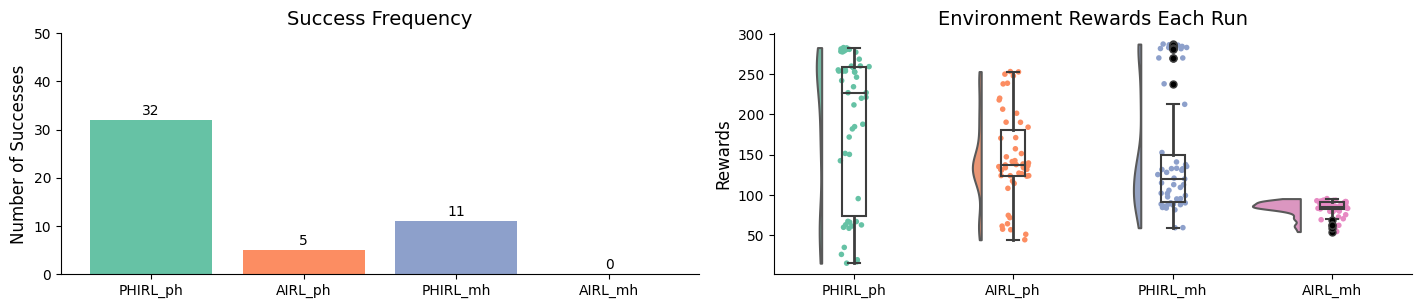

AIRL_ph_success 5
PHIRL_ph_success 32
AIRL_mh_success 0
PHIRL_mh_success 11
AIRL_ph_rewards 146.11569724144482
PHIRL_ph_rewards 186.42405282790438
AIRL_mh_rewards 83.93131398156498
PHIRL_mh_rewards 146.81643389621115


In [24]:


fig_width = 7.16*2   # width in inches
fig_height = (fig_width / 36) * 8 # height in inches to maintain 9:6 ratio for each subplot
fig, axs = plt.subplots(1,2, figsize=(fig_width, fig_height))

labels = ["PHIRL_ph", "AIRL_ph", "PHIRL_mh", "AIRL_mh"]

reward_data = [
    PHIRL_ph_rewards, 
    AIRL_ph_rewards, 
    PHIRL_mh_rewards, 
    AIRL_mh_rewards
]

success_counts = [
    PHIRL_ph_success,
    AIRL_ph_success,
    PHIRL_mh_success,
    AIRL_mh_success
]



# ========== LEFT SUBPLOT: Barplot of Success Frequency ==========
bar_colors = sns.color_palette("Set2", n_colors=len(success_counts))
bars = axs[0].bar(range(len(success_counts)), success_counts, color=bar_colors)

# Label each bar with its count
for idx, val in enumerate(success_counts):
    axs[0].text(
        idx, 
        val + 0.5,     # slightly above the top of the bar
        str(val), 
        ha='center', 
        va='bottom',
        fontsize=10
    )

axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=0)
axs[0].set_ylabel("Number of Successes", fontsize=12)
axs[0].set_title("Success Frequency", fontsize=14)
axs[0].set_ylim(0, 50)
#remove the top and right lines
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


# ========== RIGHT SUBPLOT: Rewards (Half Violin + Strip + Box) ==========
pal = sns.color_palette("Set2", n_colors=len(labels))

# Half-violin plot on the LEFT side
pt.half_violinplot(
    x=None,  
    y=None,
    data=reward_data,
    palette=pal,
    bw=.3,
    cut=0,
    scale="area",
    width=.6,
    inner=None,
    offset=0.2,      # Shift the half-violin a bit further left from center
    ax=axs[1]
)

# Stripplot (raw points) on the RIGHT side, with smaller jitter
sns.stripplot(
    data=reward_data,
    palette=pal,
    edgecolor="white",
    size=4,
    jitter=0.1,      # Smaller jitter => points will cluster more tightly
    zorder=1,
    ax=axs[1]
)

######(Optional) Boxplot overlay without outliers
sns.boxplot(
    data=reward_data, 
    width=0.15, 
    showcaps=True, 
    boxprops={'facecolor':'none', "zorder":10}, 
    showfliers=False, 
    whiskerprops={'linewidth':2, "zorder":10},
    saturation=1,
    ax=axs[1],
)

axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=0)
axs[1].set_ylabel("Rewards", fontsize=12)
axs[1].set_title("Environment Rewards Each Run", fontsize=14)
#remove the top and right lines
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


#save the figure

fig.savefig("lift_results", bbox_inches='tight', dpi=500)

print("AIRL_ph_success", AIRL_ph_success)
print("PHIRL_ph_success", PHIRL_ph_success)
print("AIRL_mh_success", AIRL_mh_success)
print("PHIRL_mh_success", PHIRL_mh_success)

print("AIRL_ph_rewards", np.mean(AIRL_ph_rewards))
print("PHIRL_ph_rewards", np.mean(PHIRL_ph_rewards))
print("AIRL_mh_rewards", np.mean(AIRL_mh_rewards))
print("PHIRL_mh_rewards", np.mean(PHIRL_mh_rewards))